In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
# other imports/set up
import keras
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.applications.vgg19 import VGG19
import cv2

Using TensorFlow backend.


In [3]:
# import the data and specify the paths
sample_submission = pd.read_csv("../input/aptos2019-blindness-detection/sample_submission.csv")
test = "../input/aptos2019-blindness-detection/test_images"
train = "../input/aptos2019-blindness-detection/train_images"
df_test = pd.read_csv("../input/aptos2019-blindness-detection/test.csv")
df_train = pd.read_csv("../input/aptos2019-blindness-detection/train.csv")

In [4]:
# look at the info of the training data
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3662 entries, 0 to 3661
Data columns (total 2 columns):
id_code      3662 non-null object
diagnosis    3662 non-null int64
dtypes: int64(1), object(1)
memory usage: 57.3+ KB


In [5]:
# look at the head of the training data
df_train.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [6]:
#https://www.kaggle.com/carlolepelaars/efficientnetb5-with-keras-aptos-2019
print("Image IDs and Labels (TRAIN)")
# Add extension to id_code
df_train['id_code'] = df_train['id_code'] + ".png"
print(f"Training images: {df_train.shape[0]}")
display(df_train.head())
print("Image IDs (TEST)")
# Add extension to id_code
df_test['id_code'] = df_test['id_code'] + ".png"
print(f"Testing Images: {df_test.shape[0]}")
display(df_test.head())

Image IDs and Labels (TRAIN)
Training images: 3662


,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


Image IDs (TEST)
Testing Images: 1928


,id_code
0,0005cfc8afb6.png
1,003f0afdcd15.png
2,006efc72b638.png
3,00836aaacf06.png
4,009245722fa4.png


In [7]:
# df columns
for i in df_train:
    print(i)

id_code
diagnosis


In [8]:
# df examples
df_train.head()

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


In [9]:
## from https://www.kaggle.com/ratthachat/aptos-eye-preprocessing-in-diabetic-retinopathy
## the below functions were obtain from another kaggle kernel
## the purpose of these functions is to take the image and to convert it to greyscale
## and to crop out the black borders,
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img
    
def preprocess_bengraham(image, sigmaX=10):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (244,244))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)  
    return image

In [10]:
# image data generators
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   validation_split=0.2,
                                  rotation_range=360,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  preprocessing_function=preprocess_bengraham)
test_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
# train generator
train_generator = train_datagen.flow_from_dataframe(df_train,
                                                    x_col='id_code', 
                                                    y_col='diagnosis', 
                                                    directory=train, 
                                                    target_size=(244,244), 
                                                    class_mode='raw',
                                                   subset='training')

# validation generator
val_generator = train_datagen.flow_from_dataframe(df_train,
                                                 x_col='id_code',
                                                 y_col='diagnosis',
                                                 directory=train,
                                                 target_size=(244,244),
                                                 class_mode='raw',
                                                 subset='validation')


Found 2930 validated image filenames.
Found 732 validated image filenames.


In [12]:
# import vgg 19 model
model_vgg19 = keras.applications.vgg19.VGG19(include_top=False, weights='imagenet',input_shape=(244,244,3))

80142336/80134624 [==============================] - 2s 0us/step


In [13]:
# get summary of vgg 19
model_vgg19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 244, 244, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 244, 244, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 244, 244, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 122, 122, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 122, 122, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 122, 122, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 61, 61, 128)       0     

In [14]:
# make vgg19 layers untrainable
for layers in model_vgg19.layers:
    layers.trainable = False

In [15]:
# create model, add fcn to vgg19
model = Sequential()
for i in model_vgg19.layers:
    model.add(i)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 244, 244, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 244, 244, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 122, 122, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 122, 122, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 122, 122, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 61, 61, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 61, 61, 256)      

In [16]:
#callbacks = [EarlyStopping(monitor='val_loss', patience=1),
#            ModelCheckpoint(filepath="bestmodel.h5", monitor='val_loss', save_best_only=True)]

In [17]:
# compile the model
model.compile(loss='sparse_categorical_crossentropy',
             optimizer=keras.optimizers.Adam(),
             metrics=['accuracy'])

In [18]:
# train the model
history = model.fit_generator(train_generator,
                             epochs=20,
                             validation_data=val_generator,
                             verbose=1)

Epoch 1/20
92/92 [==============================] - 485s 5s/step - loss: 1.6151 - accuracy: 0.6089 - val_loss: 0.6591 - val_accuracy: 0.6981
Epoch 2/20
92/92 [==============================] - 420s 5s/step - loss: 0.9431 - accuracy: 0.6713 - val_loss: 0.9711 - val_accuracy: 0.6831
Epoch 3/20
92/92 [==============================] - 423s 5s/step - loss: 0.9230 - accuracy: 0.6734 - val_loss: 0.8561 - val_accuracy: 0.7213
Epoch 4/20
92/92 [==============================] - 427s 5s/step - loss: 0.9112 - accuracy: 0.6809 - val_loss: 0.5813 - val_accuracy: 0.6913
Epoch 5/20
92/92 [==============================] - 422s 5s/step - loss: 0.8821 - accuracy: 0.6843 - val_loss: 0.8925 - val_accuracy: 0.7145
Epoch 6/20
92/92 [==============================] - 418s 5s/step - loss: 0.8796 - accuracy: 0.6952 - val_loss: 0.8241 - val_accuracy: 0.7104
Epoch 7/20
92/92 [==============================] - 419s 5s/step - loss: 0.8625 - accuracy: 0.6863 - val_loss: 0.8278 - val_accuracy: 0.7172
Epoch 8/20
92

In [19]:
# see history output
history.history

{'val_loss': [0.6590679883956909,
  0.9711194634437561,
  0.8561127781867981,
  0.5812864899635315,
  0.8925265669822693,
  0.8241289854049683,
  0.8278398513793945,
  0.8088937401771545,
  0.5994039177894592,
  0.8857079148292542,
  0.7346526384353638,
  0.6713059544563293,
  0.9934709668159485,
  0.6333404779434204,
  0.8500855565071106,
  0.5838507413864136,
  0.8333852887153625,
  0.8332614302635193,
  0.8586016893386841,
  0.5926339030265808],
 'val_accuracy': [0.6980874538421631,
  0.6830601096153259,
  0.7213114500045776,
  0.6912568211555481,
  0.7144808769226074,
  0.7103825211524963,
  0.7172130942344666,
  0.7240437269210815,
  0.7172130942344666,
  0.7281420826911926,
  0.7295082211494446,
  0.7295082211494446,
  0.7049180269241333,
  0.7240437269210815,
  0.7254098653793335,
  0.7349726557731628,
  0.7336065769195557,
  0.7226775884628296,
  0.7295082211494446,
  0.7172130942344666],
 'loss': [1.618088012099673,
  0.940757203590341,
  0.9227186431250067,
  0.90933054795444

In [20]:
# plot loss
def train_validation_loss_plot():
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(loss) + 1)
    
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    return plt.show()

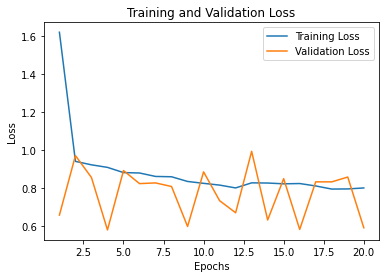

In [21]:
# plot loss
train_validation_loss_plot()

In [22]:
# plot accuracy
def train_validation_accuracy_plot():
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    epochs = range(1, len(acc) + 1)
    
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    return plt.show()

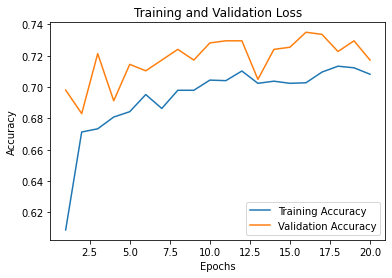

In [23]:
# plot accuracy
train_validation_accuracy_plot()